In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv("data_banknote_authentication.txt", 
                  sep=',', 
                  names=["Variance", "Skewness", "Curtosis", "Entropy", "Class"])

In [3]:
df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
df=df.dropna()

In [5]:
list = df.values.tolist()

In [6]:
def shuffle(to_shuffle):
  shuffled = []
  while len(to_shuffle)>0: 
    randomIdx = random.randint(0, len(to_shuffle)-1)
    shuffled.append(to_shuffle[randomIdx])
    del to_shuffle [randomIdx] 
  return shuffled

In [7]:
list = shuffle(list)

In [8]:
def split(list, ratio):
  train = []
  validation = []
  test = []
  for i in range(len(list)):
    if(i/len(list) < ratio[0]):
      train.append(list[:][i])
    elif (i/len(list) > ratio[0] and i/len(list) < ratio[0] + ratio[1]):
      validation.append(list[:][i])
    else:
      test.append(list[:][i])
  return train, validation, test

In [9]:
train, validation, test = split(list, [0.7,0.2])

In [10]:
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

In [11]:
def splitXandY(list, labelIdx):
  x = list[:,0:labelIdx]
  y = list[:,labelIdx]
  return x,y

In [12]:
X_train, y_train = splitXandY(train, 4)
X_validation, y_validation = splitXandY(validation, 4)
y_validation = y_validation.reshape((y_validation.shape[0],1))
X_test, y_test = splitXandY(test, 4)
y_test = y_test.reshape((y_test.shape[0],1))



In [13]:
def getMinandMax(list):
  minList = []
  maxList = []
  for i in range(len(list[0])):
    col = list[:,i]
    minList.append(min(col)) 
    maxList.append(max(col))   
  return minList, maxList

In [14]:
def normalize(list, min_list, max_list):
  newList = list.copy()
  for i in range(len(list[0])):
    col = list[:,i]
    for j in range(len(col)):
      newList[j][i] = (col[j] - min_list[i] ) / (max_list[i] - min_list[i])
  return newList

In [15]:
min_list, max_list = getMinandMax(train)
X_train_norm = normalize(X_train, min_list, max_list)
X_validation_norm = normalize(X_validation, min_list, max_list)
X_test_norm = normalize(X_test, min_list, max_list)

In [16]:
X_train_norm

array([[0.68031067, 0.68586738, 0.0128072 , 0.51369832],
       [0.69248354, 0.86217619, 0.07300924, 0.6539731 ],
       [0.50437315, 0.45536152, 0.59283176, 0.84597507],
       ...,
       [0.15861512, 0.32853128, 0.6759558 , 0.72898515],
       [0.38570264, 0.61958787, 0.13365499, 0.6019986 ],
       [0.33076607, 0.17707963, 0.60947724, 0.69817962]])

<AxesSubplot:>

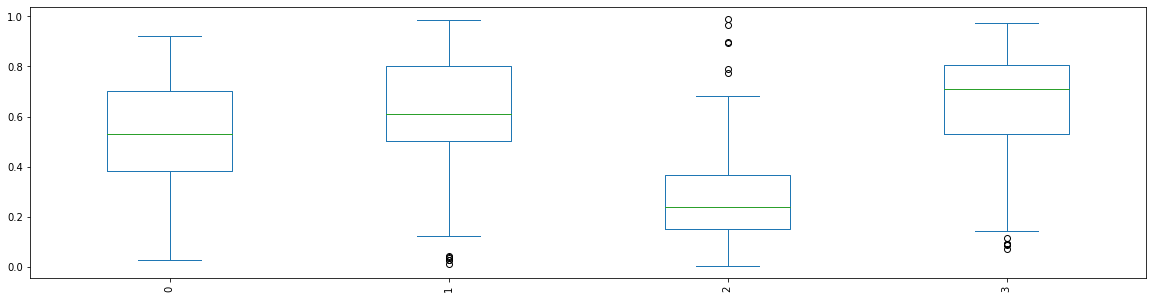

In [17]:
pd.DataFrame(X_validation_norm).plot.box(figsize=(20,5), rot=90)

In [18]:
print(len(train))
print(len(validation))
print(len(test))

961
274
137


In [19]:
def divideIntoBatches(x_list, y_list, batchLength):
  iterationNo = math.ceil(len(x_list)/batchLength)
  x_batches = []
  y_batches = []
  idx = 0
  for i in range(iterationNo):
    x_batch = []
    y_batch = []
    for j in range(batchLength):
      if(idx == len(x_list)):
        break;
      x_batch.append(x_list[idx])
      y_batch.append(y_list[idx])
      idx+=1
    # print(x_batch)
    x_batches.append(x_batch)
    y_batches.append(y_batch)
  return x_batches, y_batches

In [20]:
x_train_batches, y_train_batches = divideIntoBatches(X_train_norm, y_train, 100)
len(x_train_batches[0][0])

4

In [21]:
np.array(y_train_batches[9]).shape

(61,)

In [22]:
# accuracy calculations 
def classification_report(confusion_matrix):
    
    TP = confusion_matrix[0][0]
    TN =  confusion_matrix[1][1] 
    FN =  confusion_matrix[0][1]
    FP =  confusion_matrix[1][0]
    accuracy = (TP+TN) / (TP+FP+FN+TN)
    percision = TP/(TP+FP)
    recall = TP / (TP+FN)
    F1 = 2*(percision*recall)/(percision+recall)
    return accuracy, percision, recall, F1
    

In [23]:
def calculate_confusion_matrix (threshold, y_predicted, y_actual):
    y_classification = [] 

    for y in y_predicted: 
        if(y<threshold):
            y_classification.append(0)
        else:
            y_classification.append(1)

    confusion_matrix = np.zeros((2, 2))

    for i in range(len(y_classification)):
        if y_classification[i] == y_actual[i] and y_actual[i]==1 :
            confusion_matrix[0][0] +=1 
        elif y_classification[i] == y_actual[i] and y_actual[i]==0 :
            confusion_matrix[1][1] +=1 
        elif y_classification[i] != y_actual[i] and y_actual[i]==1 :
            confusion_matrix[0][1] +=1 
        else:
            confusion_matrix[1][0] +=1 
    return confusion_matrix


### Do some helper functions that will help in the training loop

In [24]:


#X is [100, 5]
def forward_propagation(X, first_layer_Weights, first_layer_bias, second_layer_Weights, second_layer_bias):
    hidden_z = np.dot(X , first_layer_Weights) + first_layer_bias #100x4  -- 4x10 = 100x10 
    hidden_y = sigmoid(hidden_z)
    output_z = np.dot(hidden_y, second_layer_Weights ) + second_layer_bias #100x10 -- 10x1 = 100x1
    output_y = sigmoid(output_z)
    return hidden_z, hidden_y, output_z, output_y

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def compute_dE_dy(Y, Y_hat): #100x1
    return -(Y-Y_hat)

def compute_loss(Y, Y_hat):
    return (0.5) *(Y-Y_hat)**2 
  




In [25]:
def calculate_predicted_y(X, y,first_layer_W, first_layer_b, second_layer_W, second_layer_b):
    hidden_z, hidden_y, output_z, output_y = forward_propagation(X,first_layer_W, first_layer_b, second_layer_W, second_layer_b)
    return output_y

In [26]:
def calculateValidationError(X, y,first_layer_W, first_layer_b, second_layer_W, second_layer_b):
    hidden_z, hidden_y, output_z, output_y = forward_propagation(X,first_layer_W, first_layer_b, second_layer_W, second_layer_b)
    return compute_loss(y, output_y)

#### Tasks Number: 5, 6, 7, 8

#### Task Requirement: Train the network at least 10 epochs. The backpropagation pass should be executed after each iteration (one batch). The validation is performed after each epoch. The testing is performed only once after the completion of the training.

#### Task Overview: 
#### Two for loops are done. Outer loop is to loop over the epochs, inner loop is to loop over the batches.
#### weights are randomly initilaized with the specified wights
#### Everey batch we do forward propagation and backpropagation as specified in the project report


In [38]:
y_train_batches2 = np.array(y_train_batches)
eta = 0.1
epochs=20
batches = np.array(x_train_batches).shape[0]
random_state=1
random = np.random.RandomState(random_state)
first_layer_W = random.normal(loc=0.0, scale=0.1, size=(4, 10))
first_layer_b = random.normal(loc=0.0, scale=0.1, size=(1, 10))
second_layer_W =random.normal(loc=0.0, scale=0.1, size=(10, 1))
second_layer_b = random.normal(loc=0.0, scale=0.1, size=(1, 1))
training_errors = []
validation_errors = []
training_confusion_matrices = []
validation_confusion_matrices = []
for epoch in range(epochs):
    batch_errors = []
    for batch in range (batches):
        y = np.array(y_train_batches2[batch])
        y = y.reshape((y.shape[0],1)) #convert y from vector to matrix (from (100,) to (100,1))
        X = np.array(x_train_batches[batch])
        batch_size = X.shape[0] #necessary because last batch is 61 samples not 100
        hidden_z, hidden_y, output_z, output_y = forward_propagation(X,first_layer_W, first_layer_b, second_layer_W, second_layer_b)

        error = compute_loss(y, output_y)
        batch_errors.append(np.mean(error))

        dE_dy = compute_dE_dy(y, output_y) #100x1
        # errors.append(np.mean(error))
        #dE/dy = -(y-y_hat)                reshape to be 10x100 (or(10,61)for last batch) for matmul    100x1
        second_layer_W_gradient = np.matmul(np.transpose(hidden_y), (dE_dy * output_y*(1-output_y))) #10,1
        #dE/dWi second layer =                  dz_out/dWi                          *  dE/dy_out *        dy_out/dz_out

        second_layer_b_gradient = np.sum(dE_dy * output_y*(1-output_y)) #1x1
        #dE/db second layer =          dE/dy_out *   dy_out/dz_out (sum over all training examples)
                                 #dE/dy *      dy_out/dz_out          reshaping from (100,1) to (1,100) to ease matmul                                 
        first_layer_W_gradient = np.transpose(dE_dy * output_y*(1-output_y))#.reshape((1,batch_size)) #1x100
        #                            * dz/dy_hidden (that is, the second_layer weights)
        
        first_layer_W_gradient = (np.matmul(second_layer_W, first_layer_W_gradient))#.reshape((batch_size,10)) #10x1 * 1x100 = 10x100 reshape to 100x10
        #                                               * dy_hidden/dz_hidden

        first_layer_W_gradient = (np.transpose(first_layer_W_gradient) *  (hidden_y*(1-hidden_y)))#.reshape((batch_size,10)) #100x10
        #                                  *dz_hidden/dW of first layer (that is, X)
        first_layer_W_gradient = np.matmul(np.transpose(X), first_layer_W_gradient)#4x100 * 100x10 = 4x10
        
        #same as w gradient but without last step dz_hidden/dw
        first_layer_b_gradient = np.sum(np.transpose(np.matmul(second_layer_W, (np.transpose(dE_dy * output_y*(1-output_y))))) * (hidden_y*(1-hidden_y)))

        second_layer_W -=  eta * second_layer_W_gradient
        second_layer_b -= eta * second_layer_b_gradient
        first_layer_W -= eta * first_layer_W_gradient
        first_layer_b -= eta * first_layer_b_gradient

        if(batch % 11 == 0):
            training_confusion_matrix = calculate_confusion_matrix(0.5, output_y, y)
            training_confusion_matrices.append(training_confusion_matrix)


    training_errors.append(sum(batch_errors)/len(batch_errors))
    validation_error = calculateValidationError(X_validation_norm, y_validation,first_layer_W, first_layer_b, second_layer_W, second_layer_b)
    
    y_predicted = calculate_predicted_y(X_validation_norm, y_validation,first_layer_W, first_layer_b, second_layer_W, second_layer_b)
    validation_confusion_matrix = calculate_confusion_matrix(0.5, y_predicted, y_validation)
    validation_confusion_matrices.append(validation_confusion_matrix)
        
    validation_errors.append(np.mean(validation_error))
    ##predict on validation data, calculate metrics 




C:\Users\DELL\AppData\Local\Temp\ipykernel_1380\2529145335.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train_batches2 = np.array(y_train_batches)
C:\Users\DELL\AppData\Local\Temp\ipykernel_1380\2529145335.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batches = np.array(x_train_batches).shape[0]


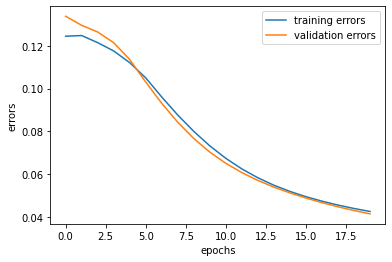

In [39]:
#PLOTTING TRAINING ERROR
x1=range(0, epochs)
y1=training_errors
y2=validation_errors
plt.plot(x1, y1, label = "training errors")
plt.plot(x1, y2, label = "validation errors")
  
# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('errors')
# giving a title to my graph
plt.title('')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

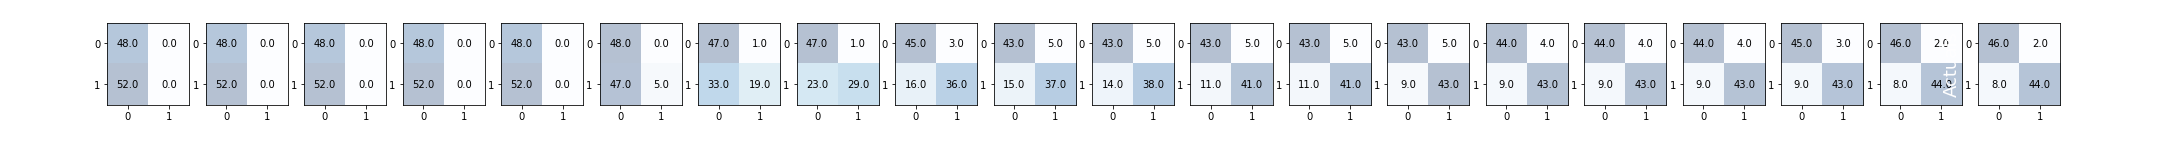

In [48]:
#plot training confusion matrices
fig, axs = plt.subplots(1, len(training_confusion_matrices), figsize=(35, 35))

# Plot each matrix in a separate subplot
for i, ax in enumerate(axs):
    im = ax.imshow(training_confusion_matrices[i], cmap=plt.cm.Blues, alpha=0.3)
    ax.set_title(f'Training confusion Matrix on epoch {50*i + 50}, batch 0',  color="w")
    plt.xlabel('Predictions', fontsize=18, color = "w")
    plt.ylabel('Actuals', fontsize=18, color = "w")
    ax.set_xticks(np.arange(training_confusion_matrices[i].shape[1]))
    ax.set_yticks(np.arange(training_confusion_matrices[i].shape[0]))
    for j in range(training_confusion_matrices[i].shape[0]):
        for k in range(training_confusion_matrices[i].shape[1]):
            text = ax.text(k, j, training_confusion_matrices[i][j, k], ha="center", va="center", color="black")

# Show the figure
plt.show()

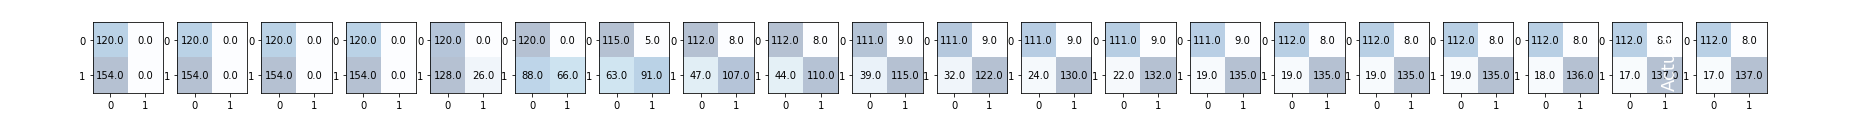

In [49]:
#plot validation confusion matrices
fig, axs = plt.subplots(1, len(validation_confusion_matrices), figsize=(30, 30))

# Plot each matrix in a separate subplot
for i, ax in enumerate(axs):
    im = ax.imshow(validation_confusion_matrices[i], cmap=plt.cm.Blues, alpha=0.3)
    ax.set_title(f'Validation confusion Matrix on epoch {50*i + 50}',  color="w")
    plt.xlabel('Predictions', fontsize=18, color = "w")
    plt.ylabel('Actuals', fontsize=18, color = "w")
    ax.set_xticks(np.arange(validation_confusion_matrices[i].shape[1]))
    ax.set_yticks(np.arange(validation_confusion_matrices[i].shape[0]))
    for j in range(validation_confusion_matrices[i].shape[0]):
        for k in range(validation_confusion_matrices[i].shape[1]):
            text = ax.text(k, j, validation_confusion_matrices[i][j, k], ha="center", va="center", color="black")
            



# Show the figure
plt.show()

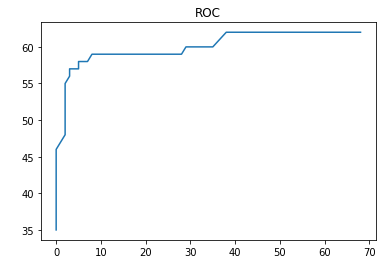

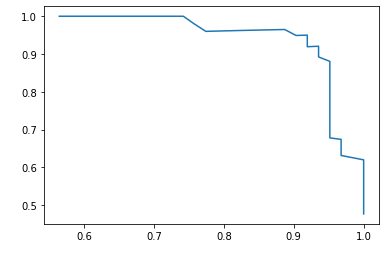

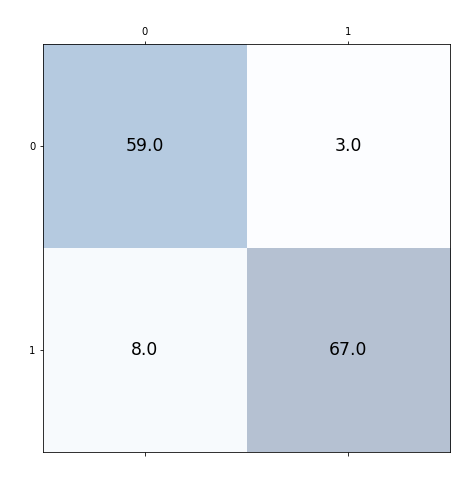

Accuracy
0.9197080291970803
Percision
0.8805970149253731
Recall
0.9516129032258065
F1 Score
0.9147286821705426


In [50]:
# draw ROC curve 
min_threshold = 0.1
threshold_step = 0.01
max_threshold = 0.9
percisions = []
recalls = []
true_positives = []
false_negatives = []

while (min_threshold<max_threshold):
    z_hidden, y_hidden, z_output, y_predicted = forward_propagation(X_test_norm,first_layer_W, first_layer_b, second_layer_W, second_layer_b)
    confusion_matrix = calculate_confusion_matrix(min_threshold, y_predicted, y_test)
    true_positives.append(confusion_matrix[0][0])
    false_negatives.append(confusion_matrix[1][0])
    accuracy, percision, recall, F1 = classification_report(confusion_matrix)
    percisions.append(percision)
    recalls.append(recall) 
    min_threshold+=threshold_step  
    

# plotting the ROC curve
plt.plot(false_negatives, true_positives)

# naming the x axis
plt.xlabel('False Positive', color = "w")
# naming the y axis
plt.ylabel('True Positive', color = "w")
plt.title('ROC')

# function to show the plot
plt.show()

# plotting the Percision Recall curve 
plt.plot(recalls, percisions)

# naming the x axis
plt.xlabel('Recall', color = "w")
# naming the y axis
plt.ylabel('Percision', color = "w")

# function to show the plot
plt.show()


z_hidden, y_hidden, z_output, y_predicted = forward_propagation(X_test_norm,first_layer_W, first_layer_b, second_layer_W, second_layer_b)
confusion_matrix = calculate_confusion_matrix(0.5, y_predicted, y_test)

# resuts of confusion matrix with threshold = 0.5
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18, color = "w")
plt.ylabel('Actuals', fontsize=18, color = "w")
plt.title('Confusion Matrix', fontsize=18, color = "w")
plt.show()

# confusion matrix with threshold = 0.5
accuracy, percision, recall, F1 = classification_report(confusion_matrix)
print('Accuracy')
print(accuracy)
print('Percision')
print(percision)
print('Recall')
print(recall)
print('F1 Score')
print(F1)